In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
from utils import access_raster
from glob import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import gaussian_kde
import seaborn as sns
import random
from scipy import optimize

In [3]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/3.Basedataset/"
aspect_path = basepath + "TPI"
hs_path = basepath + "HS"

is_tiff = lambda x: re.search(".tiff?$", x)

def get_dataframe(path, key): 
    files = filter(is_tiff, glob(path + "/**/*", recursive=True))
    df = pd.DataFrame(files, columns=[key])
    df['file'] = df[key].apply(lambda p: Path(p).parts[-2])
    df = df.set_index("file")
    return df

def get_array(raster): 
    array = raster['array'][0]
    nodata = raster['meta']['nodata']
    array[array==nodata]=0
    return array

In [4]:
df = get_dataframe(aspect_path, "TPI")[1:]
df['HS'] = get_dataframe(hs_path, "HS")['HS']
len(df)

15

In [5]:
def get_mapping(series):
    aspect_raster = access_raster(series['TPI'])
    hs_raster = access_raster(series['HS'])

    aspect_array = get_array(aspect_raster)
    hs_array = get_array(hs_raster)
    
    mapping = [[a, hs] for aspect_line, hs_line in zip(aspect_array, hs_array) 
                       for a, hs in zip(aspect_line, hs_line)
                       if hs > 0]
    
    return mapping

        
def fit_curve(x, y, ax): 
    def test_func(x, a, b, c, d):
        return a / (1 + np.exp(c*(x - d))) + b

    try:
        params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0, 1, 0],
                                                    method="trf", absolute_sigma=True, maxfev=5000)
    except RuntimeError: 
        print("Optimal parameters not found, fit won't be displayed")
        plt.show()
        return None
        

    x, y = zip(*sorted(zip(x, y)))
    x, y = np.array(x), np.array(y)
    fitted_y = test_func(x, params[0], params[1], params[2], params[3])
    ax.plot(x, fitted_y,
            label='Linear regression', color="red")
    ax.legend(loc='best')
    plt.show()    
    
    get_str = lambda x:  f"{round(x, 2)}"
    a, b, c, d = params
    print(f"Fitted function: {get_str(a)} / (1 + np.exp({get_str(c)}*(x - {get_str(d)}))) + {get_str(b)}")
    
    
    mse = np.mean((y - fitted_y) ** 2)
    print("MSE:", mse)
    ss_res = np.sum((y - fitted_y) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (ss_res / ss_tot)
    print("R^2:", r_sq)
    
    return r_sq

def plot_map(_mapping):
    mapping = deepcopy(_mapping)
    random.shuffle(mapping)

    x, y = zip(*mapping[:10000])
    x, y = np.array(x), np.array(y)
    xy = np.vstack([x,y])
    kernel = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=kernel, s=1, label="scatter plot")
    
    fit_curve(x, y, ax)
    
    return x

def plot_slices(mapping): 
    df = pd.DataFrame(mapping)
    df[0] = df[0].apply(lambda x: round(x, 2))
    new_mapping = df.groupby(0).apply(np.mean, axis=0).values

    plot_map(new_mapping)
    return df

____________________________________________________________________________________________________ 
 HS_Saflischpass_20220512_1m_epsg2056


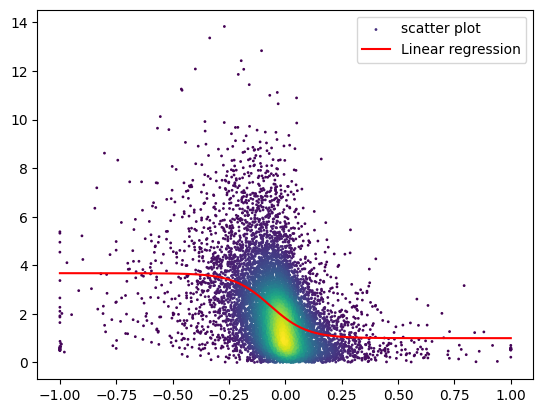

Fitted function: 2.68 / (1 + np.exp(12.15*(x - -0.07))) + 1.0
MSE: 2.3679998
R^2: 0.17682307958602905


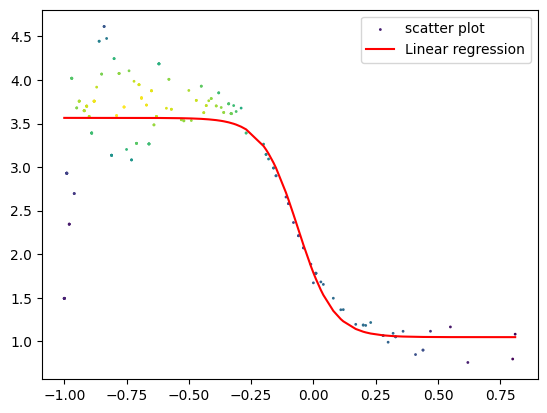

Fitted function: 2.52 / (1 + np.exp(13.96*(x - -0.06))) + 1.05
MSE: 0.25481485990477337
R^2: 0.7401495619786727
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220511_1m_epsg2056


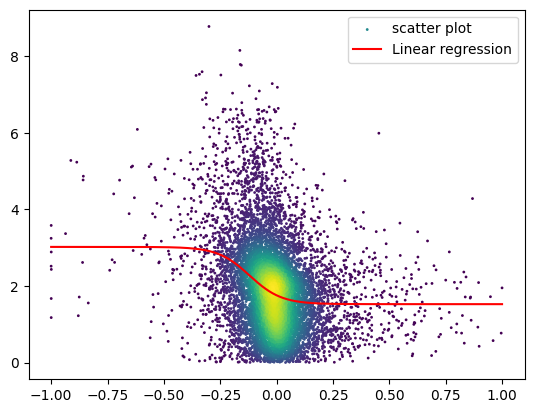

Fitted function: 1.49 / (1 + np.exp(14.19*(x - -0.12))) + 1.53
MSE: 1.2651346
R^2: 0.09816688299179077


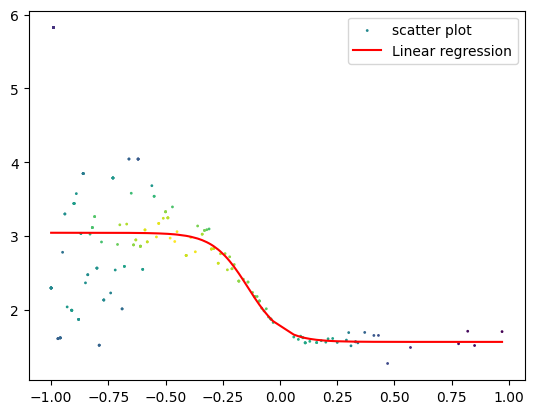

Fitted function: 1.48 / (1 + np.exp(13.14*(x - -0.14))) + 1.56
MSE: 0.6175610658250742
R^2: 0.33357278119453193
____________________________________________________________________________________________________ 
 snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser


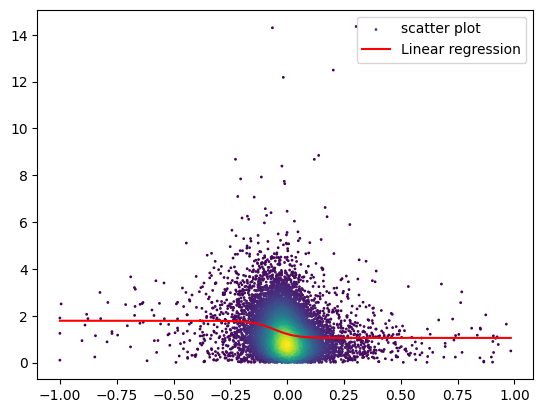

Fitted function: 0.73 / (1 + np.exp(21.2*(x - -0.06))) + 1.05
MSE: 0.91536546
R^2: 0.04678750038146973


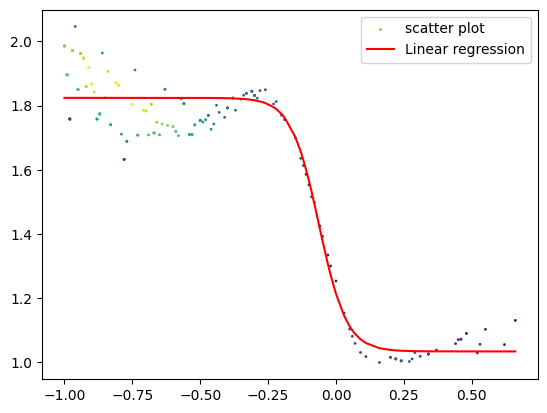

Fitted function: 0.79 / (1 + np.exp(19.55*(x - -0.06))) + 1.03
MSE: 0.006216142955273481
R^2: 0.9348463311345405
____________________________________________________________________________________________________ 
 HS_Davos_20200406_2m_epsg2056


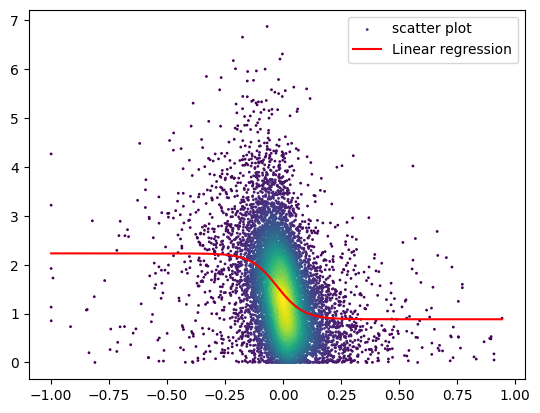

Fitted function: 1.35 / (1 + np.exp(17.51*(x - -0.03))) + 0.88
MSE: 0.8012065
R^2: 0.15070247650146484


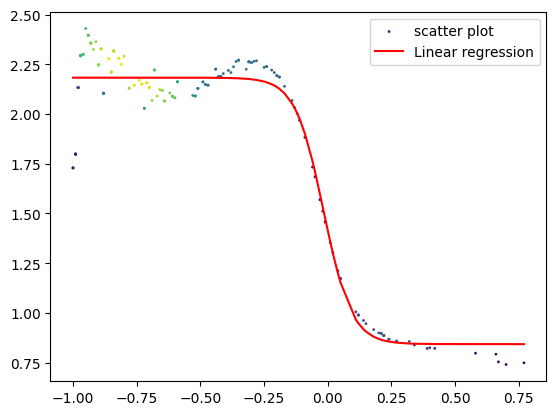

Fitted function: 1.34 / (1 + np.exp(18.06*(x - -0.02))) + 0.84
MSE: 0.014051348650024083
R^2: 0.9389846450530182
____________________________________________________________________________________________________ 
 HS_Davos_20211604_2m_epsg2056


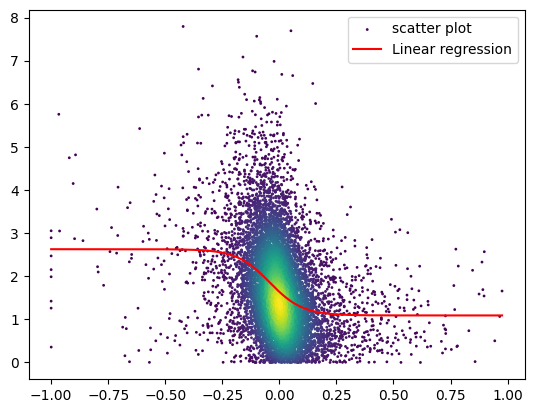

Fitted function: 1.54 / (1 + np.exp(13.89*(x - -0.04))) + 1.09
MSE: 1.0000863
R^2: 0.12658345699310303


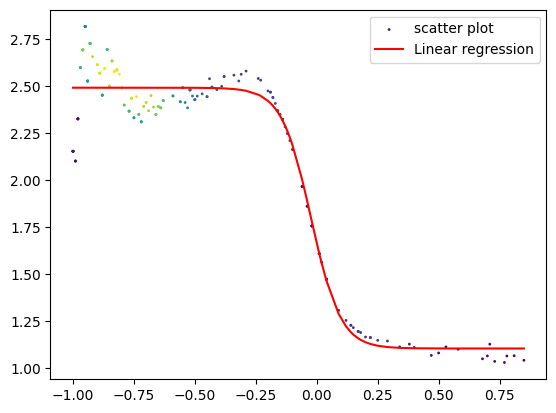

Fitted function: 1.39 / (1 + np.exp(16.58*(x - -0.02))) + 1.1
MSE: 0.017082665118441826
R^2: 0.9338766495989342
____________________________________________________________________________________________________ 
 snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser


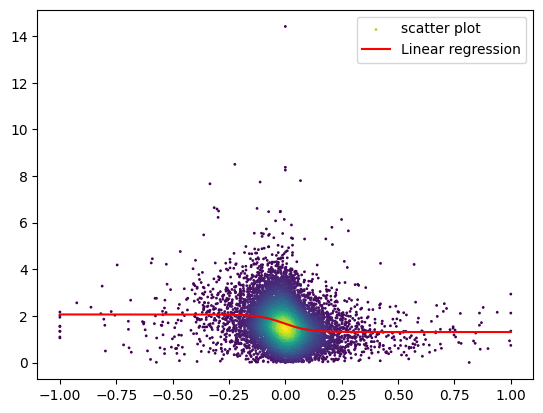

Fitted function: 0.75 / (1 + np.exp(17.87*(x - -0.01))) + 1.31
MSE: 0.73951316
R^2: 0.058538854122161865


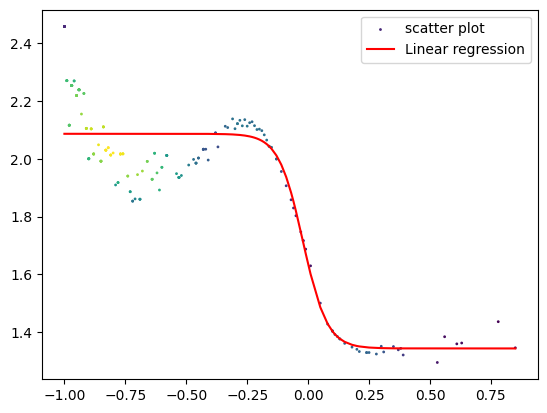

Fitted function: 0.74 / (1 + np.exp(20.13*(x - -0.02))) + 1.34
MSE: 0.014916672777963005
R^2: 0.8180187481916767
____________________________________________________________________________________________________ 
 snowmap_2012_ads_80_extent_maskiert_nosnow0_noausreisser


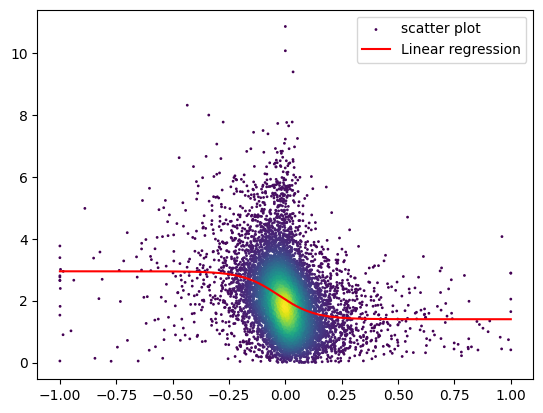

Fitted function: 1.55 / (1 + np.exp(12.44*(x - -0.03))) + 1.4
MSE: 1.1655538
R^2: 0.10483455657958984


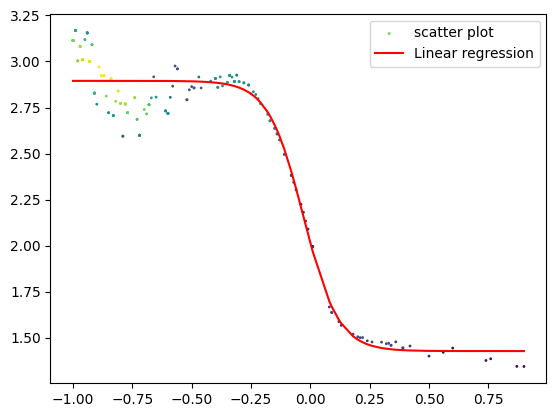

Fitted function: 1.47 / (1 + np.exp(13.56*(x - -0.03))) + 1.43
MSE: 0.016376875932396895
R^2: 0.9361969651286447
____________________________________________________________________________________________________ 
 snowmap_2015_ads_100_extent_maskiert_nosnow0_noausreisser


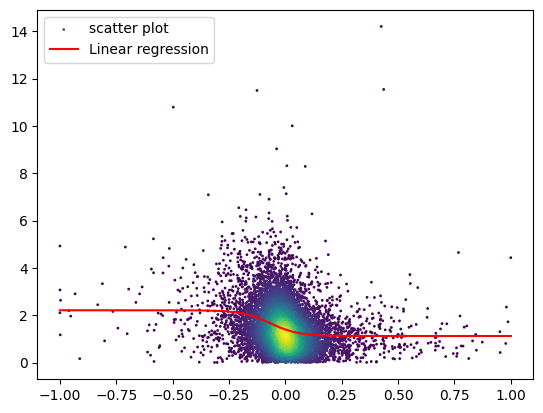

Fitted function: 1.09 / (1 + np.exp(15.92*(x - -0.07))) + 1.12
MSE: 0.91529083
R^2: 0.07400214672088623


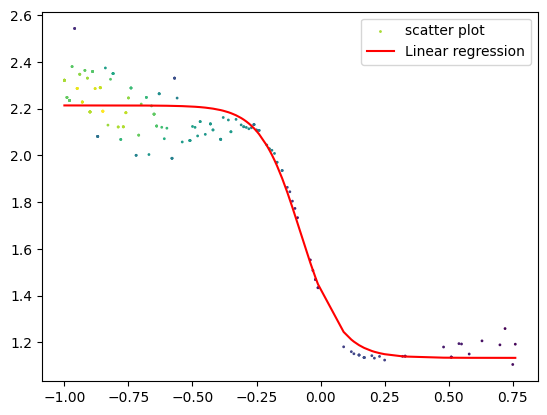

Fitted function: 1.08 / (1 + np.exp(12.78*(x - -0.08))) + 1.13
MSE: 0.008646848748164102
R^2: 0.9432083486050196
____________________________________________________________________________________________________ 
 snowmap_20160126_ads_100_extent_maskiert_nosnow0_noausreisser


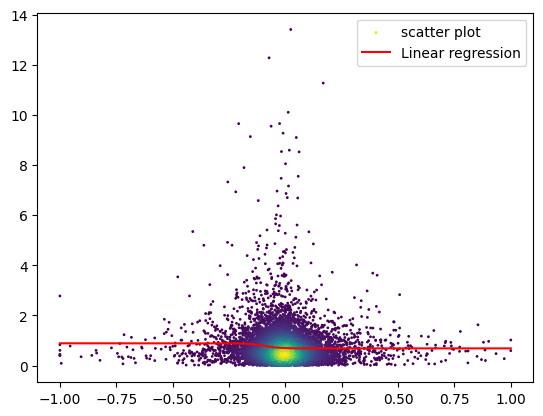

Fitted function: 0.2 / (1 + np.exp(30.76*(x - -0.09))) + 0.68
MSE: 0.51777047
R^2: 0.006526768207550049


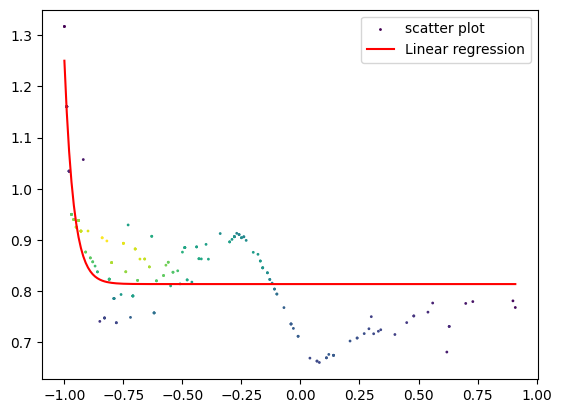

Fitted function: 11732.43 / (1 + np.exp(26.06*(x - -1.39))) + 0.81
MSE: 0.004323654454778928
R^2: 0.6781744953679745
____________________________________________________________________________________________________ 
 HS_c_20220223_1m_epsg2056


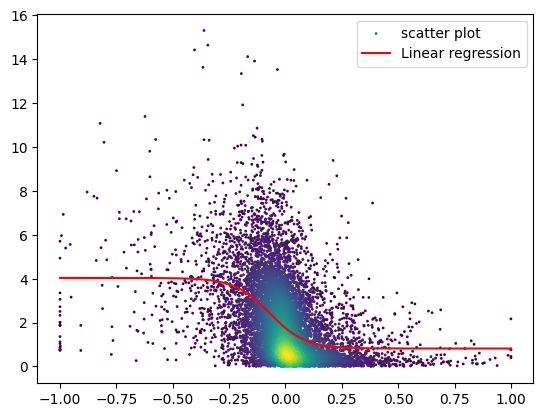

Fitted function: 3.22 / (1 + np.exp(12.78*(x - -0.07))) + 0.82
MSE: 2.619666
R^2: 0.21490180492401123


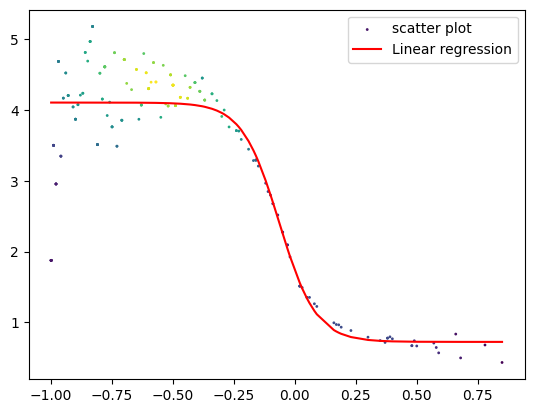

Fitted function: 3.38 / (1 + np.exp(13.16*(x - -0.06))) + 0.72
MSE: 0.3351316326528614
R^2: 0.805942720758247
____________________________________________________________________________________________________ 
 HS_Davos_20170316_2m_epsg2056


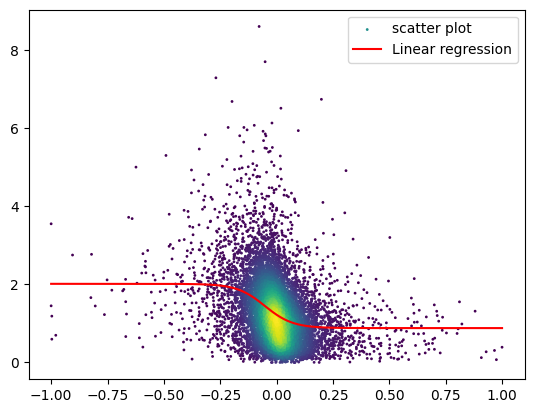

In [6]:
for index, series in df.iterrows(): 
    print("_"*100, "\n", series.name)
    mapping = get_mapping(series)
    plot_map(mapping)
    new_mapping = plot_slices(mapping)